# Model Selection and Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle as pkl

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, roc_auc_score, log_loss
from sklearn.inspection import permutation_importance

## Baseline model

In [2]:
df_mf_train = pd.read_csv('../Data/df_mf_train.csv')

In [3]:
df_mf_train.head()

,Ticker,Morningstar Sustainability Rating,ROE Last Year (%),Debt/Capital Last Year (%),No. of Holdings in Portfolio,% Assets in Top 10 Holdings,Turnover Ratio (%),Average Manager Tenure (years),Expense Ratio (%),Minimum Initial Purchase ($),Total Assets ($ mil),3-year Annualized Return vs. S&P500,Outperform / Underperform,"No-load Funds (Yes=1, No=0)","Closed to New Investors (Yes=1, No=0)"
0,VFTNX,4,28.22,45.19,470,30.13,18,5,0.12,5000000,10798,4.48,1,1,0
1,JCNNX,1,10.25,48.60,45,44.05,68,4,0.58,1000000,3785,7.61,1,1,0
2,PMJPX,4,0.62,46.75,782,12.57,202,6,0.63,1000000,552,-4.02,0,1,0
3,WMICX,2,-6.53,30.18,75,25.07,75,10,1.66,2000,1410,23.85,1,1,0
4,STAEX,3,24.25,45.50,39,47.94,16,8,1.02,1000,287,9.69,1,0,0


In [4]:
X_train_base = df_mf_train.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y_train_base = df_mf_train['Outperform / Underperform']

### Logistic regression

#### Gridsearch

In [5]:
param_grid_log = {'C': [10, 100, 1000, 2000]} 

In [6]:
grid_log = GridSearchCV(LogisticRegression(max_iter=1000),param_grid_log,refit=True,n_jobs=-1)

In [7]:
grid_log.fit(X_train_base,y_train_base)

GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [10, 100, 1000, 2000]})

In [8]:
grid_log.best_params_

{'C': 10}

In [9]:
accuracy_cv_log = cross_val_score(grid_log, X_train_base, y_train_base, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [10]:
accuracy_cv_log

0.5238465565899194

In [11]:
precision_cv_log = cross_val_score(grid_log, X_train_base, y_train_base, cv=5, scoring='precision',n_jobs=-1).mean()

In [12]:
precision_cv_log

0.5184014124246024

In [13]:
recall_cv_log = cross_val_score(grid_log, X_train_base, y_train_base, cv=5, scoring='recall',n_jobs=-1).mean()

In [14]:
recall_cv_log

0.4821428571428571

In [15]:
f1_cv_log = cross_val_score(grid_log, X_train_base, y_train_base, cv=5, scoring='f1',n_jobs=-1).mean()

In [16]:
f1_cv_log

0.3686785938587884

In [17]:
roc_cv_log = cross_val_score(grid_log, X_train_base, y_train_base, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [18]:
roc_cv_log

0.6145564317157362

In [19]:
logloss_cv_log = -cross_val_score(grid_log, X_train_base, y_train_base, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [20]:
logloss_cv_log

0.6856714195378827

### K nearest neighbors

In [21]:
scaler = StandardScaler()

In [22]:
X_train_base_scaled = scaler.fit_transform(X_train_base)

#### Gridsearch

In [23]:
param_grid_knn = {'n_neighbors': range(1,11), 'weights': ['uniform', 'distance'], 'metric': ['euclidean','manhattan']} 

In [24]:
grid_knn = GridSearchCV(KNeighborsClassifier(),param_grid_knn,refit=True,n_jobs=-1)

In [25]:
grid_knn.fit(X_train_base_scaled,y_train_base)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 11),
                         'weights': ['uniform', 'distance']})

In [26]:
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [27]:
accuracy_cv_knn = cross_val_score(grid_knn, X_train_base_scaled, y_train_base, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [28]:
accuracy_cv_knn

0.9226698080680382

In [29]:
precision_cv_knn = cross_val_score(grid_knn, X_train_base_scaled, y_train_base, cv=5, scoring='precision',n_jobs=-1).mean()

In [30]:
precision_cv_knn

0.9101396096598526

In [31]:
recall_cv_knn = cross_val_score(grid_knn, X_train_base_scaled, y_train_base, cv=5, scoring='recall',n_jobs=-1).mean()

In [32]:
recall_cv_knn

0.9077380952380952

In [33]:
f1_cv_knn = cross_val_score(grid_knn, X_train_base_scaled, y_train_base, cv=5, scoring='f1',n_jobs=-1).mean()

In [34]:
f1_cv_knn

0.908788975435602

In [35]:
roc_cv_knn = cross_val_score(grid_knn, X_train_base_scaled, y_train_base, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [36]:
roc_cv_knn

0.9648915873704407

In [37]:
logloss_cv_knn = -cross_val_score(grid_knn, X_train_base_scaled, y_train_base, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [38]:
logloss_cv_knn

0.7629233683417315

### Decision Tree 

#### Gridsearch

In [39]:
param_grid_dtree = {'criterion': ['gini','entropy'], 'max_depth': range(1,10), 'min_samples_split': range(1,5), 'min_samples_leaf': range(1,5)} 

In [40]:
grid_dtree = GridSearchCV(DecisionTreeClassifier(),param_grid_dtree,refit=True,n_jobs=-1)

In [41]:
grid_dtree.fit(X_train_base,y_train_base)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5)})

In [42]:
grid_dtree.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [43]:
accuracy_cv_dtree = cross_val_score(grid_dtree, X_train_base, y_train_base, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [44]:
accuracy_cv_dtree

0.903215466932281

In [45]:
precision_cv_dtree = cross_val_score(grid_dtree, X_train_base, y_train_base, cv=5, scoring='precision',n_jobs=-1).mean()

In [46]:
precision_cv_dtree

0.9005723601907064

In [47]:
recall_cv_dtree = cross_val_score(grid_dtree, X_train_base, y_train_base, cv=5, scoring='recall',n_jobs=-1).mean()

In [48]:
recall_cv_dtree

0.8589285714285715

In [49]:
f1_cv_dtree = cross_val_score(grid_dtree, X_train_base, y_train_base, cv=5, scoring='f1',n_jobs=-1).mean()

In [50]:
f1_cv_dtree

0.8848096666525883

In [51]:
roc_cv_dtree = cross_val_score(grid_dtree, X_train_base, y_train_base, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [52]:
roc_cv_dtree

0.9442915610913729

In [53]:
logloss_cv_dtree = -cross_val_score(grid_dtree, X_train_base, y_train_base, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [54]:
logloss_cv_dtree

1.0132339932184289

### Random forest

#### Gridsearch

In [55]:
param_grid_rfc = {'bootstrap': [False],
              'max_depth': [1, 5, 10],
              'max_features': ['auto'],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 3],
              'n_estimators': [25, 50, 75]
             }

In [56]:
grid_rfc = GridSearchCV(RandomForestClassifier(),param_grid_rfc,refit=True,n_jobs=-1)

In [57]:
grid_rfc.fit(X_train_base,y_train_base)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [1, 5, 10],
                         'max_features': ['auto'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [25, 50, 75]})

In [58]:
grid_rfc.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 75}

In [59]:
accuracy_cv_rfc = cross_val_score(grid_rfc, X_train_base, y_train_base, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [60]:
accuracy_cv_rfc

0.947943403695616

In [61]:
precision_cv_rfc = cross_val_score(grid_rfc, X_train_base, y_train_base, cv=5, scoring='precision',n_jobs=-1).mean()

In [62]:
precision_cv_rfc

0.9605020766605143

In [63]:
recall_cv_rfc = cross_val_score(grid_rfc, X_train_base, y_train_base, cv=5, scoring='recall',n_jobs=-1).mean()

In [64]:
recall_cv_rfc

0.9166666666666667

In [65]:
f1_cv_rfc = cross_val_score(grid_rfc, X_train_base, y_train_base, cv=5, scoring='f1',n_jobs=-1).mean()

In [66]:
f1_cv_rfc

0.9390990980062422

In [67]:
roc_cv_rfc = cross_val_score(grid_rfc, X_train_base, y_train_base, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [68]:
roc_cv_rfc

0.9864830861494396

In [69]:
logloss_cv_rfc = -cross_val_score(grid_rfc, X_train_base, y_train_base, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [70]:
logloss_cv_rfc

0.19981369917763434

### Support Vector Machine

#### Gridsearch

In [71]:
param_grid_svc = {'C': [10, 100, 1000], 'gamma': [0.2,0.5,1], 'kernel': ['rbf']} 

In [72]:
grid_svc = GridSearchCV(SVC(),param_grid_svc,refit=True,n_jobs=-1)

In [73]:
grid_svc.fit(X_train_base_scaled,y_train_base)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [10, 100, 1000], 'gamma': [0.2, 0.5, 1],
                         'kernel': ['rbf']})

In [74]:
grid_svc.best_params_

{'C': 100, 'gamma': 0.5, 'kernel': 'rbf'}

In [75]:
accuracy_cv_svc = cross_val_score(grid_svc, X_train_base_scaled, y_train_base, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [76]:
accuracy_cv_svc

0.8958836149101636

In [77]:
precision_cv_svc = cross_val_score(grid_svc, X_train_base_scaled, y_train_base, cv=5, scoring='precision',n_jobs=-1).mean()

In [78]:
precision_cv_svc

0.899347764522638

In [79]:
recall_cv_svc = cross_val_score(grid_svc, X_train_base_scaled, y_train_base, cv=5, scoring='recall',n_jobs=-1).mean()

In [80]:
recall_cv_svc

0.85

In [81]:
f1_cv_svc = cross_val_score(grid_svc, X_train_base_scaled, y_train_base, cv=5, scoring='f1',n_jobs=-1).mean()

In [82]:
f1_cv_svc

0.8739045205627131

In [83]:
roc_cv_svc = cross_val_score(grid_svc, X_train_base_scaled, y_train_base, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [84]:
roc_cv_svc

0.9479072796460013

### Naive Bayes

#### Gridsearch

In [85]:
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

In [86]:
grid_nb = GridSearchCV(GaussianNB(),param_grid_nb,refit=True,n_jobs=-1)

In [87]:
grid_nb.fit(X_train_base,y_train_base)

GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [88]:
grid_nb.best_params_

{'var_smoothing': 4.328761281083062e-05}

In [89]:
accuracy_cv_nb = cross_val_score(grid_nb, X_train_base, y_train_base, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [90]:
accuracy_cv_nb

0.5855409339922615

In [91]:
precision_cv_nb = cross_val_score(grid_nb, X_train_base, y_train_base, cv=5, scoring='precision',n_jobs=-1).mean()

In [92]:
precision_cv_nb

0.6849544072948328

In [93]:
recall_cv_nb = cross_val_score(grid_nb, X_train_base, y_train_base, cv=5, scoring='recall',n_jobs=-1).mean()

In [94]:
recall_cv_nb

0.05892857142857143

In [95]:
f1_cv_nb = cross_val_score(grid_nb, X_train_base, y_train_base, cv=5, scoring='f1',n_jobs=-1).mean()

In [96]:
f1_cv_nb

0.1070655400976273

In [97]:
roc_cv_nb = cross_val_score(grid_nb, X_train_base, y_train_base, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [98]:
roc_cv_nb

0.6137943014587751

In [99]:
logloss_cv_nb = -cross_val_score(grid_nb, X_train_base, y_train_base, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [100]:
logloss_cv_nb

1.231576053590612

### XG Boost

#### Gridsearch

In [101]:
param_grid_xgb = {'n_estimators': [100],  
                  'max_depth': range(3,5),
                  'learning_rate': [0.4,0.5,0.6],
                  'subsample': [0.6,0.75, 0.9],
                  'colsample_bytree': [0.4,0.5,0.6]
                }

In [102]:
grid_xgb = GridSearchCV(xgb.XGBClassifier(),param_grid_xgb,refit=True,n_jobs=-1)

In [103]:
grid_xgb.fit(X_train_base,y_train_base)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [104]:
grid_xgb.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.6,
 'max_depth': 4,
 'n_estimators': 100,
 'subsample': 0.9}

In [105]:
accuracy_cv_xgb = cross_val_score(grid_xgb, X_train_base, y_train_base, cv=5, scoring='accuracy', n_jobs=-1).mean()

In [106]:
accuracy_cv_xgb

0.9560344277158437

In [107]:
precision_cv_xgb = cross_val_score(grid_xgb, X_train_base, y_train_base, cv=5, scoring='precision', n_jobs=-1).mean()

In [108]:
precision_cv_xgb

0.9564193199883831

In [109]:
recall_cv_xgb = cross_val_score(grid_xgb, X_train_base, y_train_base, cv=5, scoring='recall', n_jobs=-1).mean()

In [110]:
recall_cv_xgb

0.9392857142857143

In [111]:
f1_cv_xgb = cross_val_score(grid_xgb, X_train_base, y_train_base, cv=5, scoring='f1', n_jobs=-1).mean()

In [112]:
f1_cv_xgb

0.9477326025540315

In [113]:
roc_cv_xgb = cross_val_score(grid_xgb, X_train_base, y_train_base, cv=5, scoring='roc_auc', n_jobs=-1).mean()

In [114]:
roc_cv_xgb

0.9854888968070359

In [115]:
logloss_cv_xgb = -cross_val_score(grid_xgb, X_train_base, y_train_base, cv=5, scoring='neg_log_loss', n_jobs=-1).mean()

In [116]:
logloss_cv_xgb

0.13864560859074704

## Model Set 2

In [117]:
df2_mf_train = pd.read_csv('../Data/df2_mf_train.csv')

In [118]:
df2_mf_train.head()

,Ticker,Debt/Capital Last Year (%),% Assets in Top 10 Holdings,3-year Annualized Return vs. S&P500,Outperform / Underperform
0,VFTNX,45.19,30.13,4.48,1
1,JCNNX,48.60,44.05,7.61,1
2,PMJPX,46.75,12.57,-4.02,0
3,WMICX,30.18,25.07,23.85,1
4,STAEX,45.50,47.94,9.69,1


In [119]:
X2_train = df2_mf_train.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y2_train = df2_mf_train['Outperform / Underperform']

### Logistic regression

#### Gridsearch

In [120]:
param_grid2_log = {'penalty': ['l1','l2'], 'C': [10, 100, 1000, 2000]} 

In [121]:
grid2_log = GridSearchCV(LogisticRegression(),param_grid2_log,refit=True,n_jobs=-1)

In [122]:
grid2_log.fit(X2_train,y2_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 100, 1000, 2000], 'penalty': ['l1', 'l2']})

In [123]:
grid2_log.best_params_

{'C': 10, 'penalty': 'l2'}

In [124]:
accuracy_cv_log2 = cross_val_score(grid2_log, X2_train, y2_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [125]:
accuracy_cv_log2

0.7510726736390453

In [126]:
precision_cv_log2 = cross_val_score(grid2_log, X2_train, y2_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [127]:
precision_cv_log2

0.7449678394453164

In [128]:
recall_cv_log2 = cross_val_score(grid2_log, X2_train, y2_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [129]:
recall_cv_log2

0.6291666666666667

In [130]:
f1_cv_log2 = cross_val_score(grid2_log, X2_train, y2_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [131]:
f1_cv_log2

0.6821441010658411

In [132]:
roc_cv_log2 = cross_val_score(grid2_log, X2_train, y2_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [133]:
roc_cv_log2

0.8120523923132007

In [134]:
logloss_cv_log2 = -cross_val_score(grid2_log, X2_train, y2_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [135]:
logloss_cv_log2

0.5620795693865646

### K nearest neighbors

In [136]:
scaler = StandardScaler()

In [137]:
X2_train_scaled = scaler.fit_transform(X2_train)

#### Gridsearch

In [138]:
param_grid2_knn = {'n_neighbors': list(range(1,5)), 'weights': ['uniform', 'distance'], 'metric': ['euclidean','manhattan']} 

In [139]:
grid2_knn = GridSearchCV(KNeighborsClassifier(),param_grid2_knn,refit=True,n_jobs=-1)

In [140]:
grid2_knn.fit(X2_train_scaled, y2_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']})

In [141]:
grid2_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}

In [142]:
accuracy_cv_knn2 = cross_val_score(grid2_knn, X2_train_scaled, y2_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [143]:
accuracy_cv_knn2

0.9451662644140519

In [144]:
precision_cv_knn2 = cross_val_score(grid2_knn, X2_train_scaled, y2_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [145]:
precision_cv_knn2

0.9322642558264912

In [146]:
recall_cv_knn2 = cross_val_score(grid2_knn, X2_train_scaled, y2_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [147]:
recall_cv_knn2

0.9392857142857143

In [148]:
f1_cv_knn2 = cross_val_score(grid2_knn, X2_train_scaled, y2_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [149]:
f1_cv_knn2

0.9356749482449087

In [150]:
roc_cv_knn2 = cross_val_score(grid2_knn, X2_train_scaled, y2_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [151]:
roc_cv_knn2

0.9568703093585611

In [152]:
logloss_cv_knn2 = -cross_val_score(grid2_knn, X2_train_scaled, y2_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [153]:
logloss_cv_knn2

1.4434209050904623

### Decision Tree 

#### Gridsearch

In [154]:
param_grid2_dtree = {'criterion': ['gini','entropy'], 'max_depth': range(1,10), 'min_samples_split': range(1,5), 'min_samples_leaf': range(1,5)} 

In [155]:
grid2_dtree = GridSearchCV(DecisionTreeClassifier(),param_grid2_dtree,refit=True,n_jobs=-1)

In [156]:
grid2_dtree.fit(X2_train,y2_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5)})

In [157]:
grid2_dtree.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [158]:
accuracy_cv_dtree2 = cross_val_score(grid2_dtree, X2_train, y2_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [159]:
accuracy_cv_dtree2

0.8392754983462949

In [160]:
precision_cv_dtree2 = cross_val_score(grid2_dtree, X2_train, y2_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [161]:
precision_cv_dtree2

0.8041027021809187

In [162]:
recall_cv_dtree2 = cross_val_score(grid2_dtree, X2_train, y2_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [163]:
recall_cv_dtree2

0.8232142857142858

In [164]:
f1_cv_dtree2 = cross_val_score(grid2_dtree, X2_train, y2_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [165]:
f1_cv_dtree2

0.8121588135308189

In [166]:
roc_cv_dtree2 = cross_val_score(grid2_dtree, X2_train, y2_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [167]:
roc_cv_dtree2

0.9047984444283786

In [168]:
logloss_cv_dtree2 = -cross_val_score(grid2_dtree, X2_train, y2_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [169]:
logloss_cv_dtree2

1.0791133282615069

### Random forest

#### Gridsearch

In [170]:
param_grid2_rfc = {'bootstrap': [False],
              'max_depth': [1, 5, 10],
              'max_features': ['auto'],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 3],
              'n_estimators': [25, 50, 75]
             }

In [171]:
grid2_rfc = GridSearchCV(RandomForestClassifier(),param_grid2_rfc,refit=True,n_jobs=-1)

In [172]:
grid2_rfc.fit(X2_train,y2_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [1, 5, 10],
                         'max_features': ['auto'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [25, 50, 75]})

In [173]:
grid2_rfc.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 25}

In [174]:
accuracy_cv_rfc2 = cross_val_score(grid2_rfc, X2_train, y2_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [175]:
accuracy_cv_rfc2

0.8915871738880587

In [176]:
precision_cv_rfc2 = cross_val_score(grid2_rfc, X2_train, y2_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [177]:
precision_cv_rfc2

0.8630833583033353

In [178]:
recall_cv_rfc2 = cross_val_score(grid2_rfc, X2_train, y2_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [179]:
recall_cv_rfc2

0.880952380952381

In [180]:
f1_cv_rfc2 = cross_val_score(grid2_rfc, X2_train, y2_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [181]:
f1_cv_rfc2

0.8739987250293122

In [182]:
roc_cv_rfc2 = cross_val_score(grid2_rfc, X2_train, y2_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [183]:
roc_cv_rfc2

0.9546953148668373

In [184]:
logloss_cv_rfc2 = -cross_val_score(grid2_rfc, X2_train, y2_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [185]:
logloss_cv_rfc2

0.313506189831674

### Support Vector Machine

#### Gridsearch

In [186]:
# param_grid2_svc = {'C': [10000, 20000], 'gamma': [1], 'kernel': ['rbf']} 

In [187]:
# grid2_svc = GridSearchCV(SVC(),param_grid2_svc,refit=True,n_jobs=-1)

In [188]:
# grid2_svc.fit(X2_train_scaled,y2_train)

In [189]:
# grid2_svc.best_params_

In [190]:
svc2 = SVC(C=20000, gamma=1, kernel='rbf')

In [191]:
svc2.fit(X2_train_scaled, y2_train)

SVC(C=20000, gamma=1)

In [192]:
accuracy_cv_svc2 = cross_val_score(svc2, X2_train_scaled, y2_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [193]:
accuracy_cv_svc2

0.7819117215134914

In [194]:
precision_cv_svc2 = cross_val_score(svc2, X2_train_scaled, y2_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [195]:
precision_cv_svc2

0.7637610922418718

In [196]:
recall_cv_svc2 = cross_val_score(svc2, X2_train_scaled, y2_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [197]:
recall_cv_svc2

0.7047619047619048

In [198]:
f1_cv_svc2 = cross_val_score(svc2, X2_train_scaled, y2_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [199]:
f1_cv_svc2

0.7329027807381661

In [200]:
roc_cv_svc2 = cross_val_score(svc2, X2_train_scaled, y2_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [201]:
roc_cv_svc2

0.8398874188676819

### Naive Bayes

#### Gridsearch

In [202]:
param_grid2_nb = {'var_smoothing': np.logspace(0,-20, 50)}

In [203]:
grid2_nb = GridSearchCV(GaussianNB(),param_grid2_nb,refit=True,n_jobs=-1)

In [204]:
grid2_nb.fit(X2_train,y2_train)

GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 3.90693994e-01, 1.52641797e-01, 5.96362332e-02,
       2.32995181e-02, 9.10298178e-03, 3.55648031e-03, 1.38949549e-03,
       5.42867544e-04, 2.12095089e-04, 8.28642773e-05, 3.23745754e-05,
       1.26485522e-05, 4.94171336e-06, 1.93069773e-06, 7.54312006e-07,
       2.94705170e-07, 1.15139540e-07...
       1.59985872e-10, 6.25055193e-11, 2.44205309e-11, 9.54095476e-12,
       3.72759372e-12, 1.45634848e-12, 5.68986603e-13, 2.22299648e-13,
       8.68511374e-14, 3.39322177e-14, 1.32571137e-14, 5.17947468e-15,
       2.02358965e-15, 7.90604321e-16, 3.08884360e-16, 1.20679264e-16,
       4.71486636e-17, 1.84206997e-17, 7.19685673e-18, 2.81176870e-18,
       1.09854114e-18, 4.29193426e-19, 1.67683294e-19, 6.55128557e-20,
       2.55954792e-20, 1.00000000e-20])})

In [205]:
grid2_nb.best_params_

{'var_smoothing': 0.0005428675439323859}

In [206]:
accuracy_cv_nb2 = cross_val_score(grid2_nb, X2_train, y2_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [207]:
accuracy_cv_nb2

0.7376767038271463

In [208]:
precision_cv_nb2 = cross_val_score(grid2_nb, X2_train, y2_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [209]:
precision_cv_nb2

0.7504284908754808

In [210]:
recall_cv_nb2 = cross_val_score(grid2_nb, X2_train, y2_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [211]:
recall_cv_nb2

0.5726190476190476

In [212]:
f1_cv_nb2 = cross_val_score(grid2_nb, X2_train, y2_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [213]:
f1_cv_nb2

0.6494601932224686

In [214]:
roc_cv_nb2 = cross_val_score(grid2_nb, X2_train, y2_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [215]:
roc_cv_nb2

0.8131309213968988

In [216]:
logloss_cv_nb2 = -cross_val_score(grid2_nb, X2_train, y2_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [217]:
logloss_cv_nb2

0.5630760865459041

### XG Boost

#### Gridsearch

In [218]:
param_grid2_xgb = {'n_estimators': [100],  
                  'max_depth': range(2,4),
                  'learning_rate': [0.25,0.5],
                  'subsample': [0.25,0.5,0.75],
                  'colsample_bytree': [0.25,0.5,0.75]
                }

In [219]:
grid2_xgb = GridSearchCV(xgb.XGBClassifier(),param_grid2_xgb,refit=True,n_jobs=-1)

In [220]:
grid2_xgb.fit(X2_train,y2_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [221]:
grid2_xgb.best_params_

{'colsample_bytree': 0.25,
 'learning_rate': 0.5,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.75}

In [222]:
accuracy_cv_xgb2 = cross_val_score(grid2_xgb, X2_train, y2_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [223]:
accuracy_cv_xgb2

0.8599982122106017

In [224]:
precision_cv_xgb2 = cross_val_score(grid2_xgb, X2_train, y2_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [225]:
precision_cv_xgb2

0.8433645734765418

In [226]:
recall_cv_xgb2 = cross_val_score(grid2_xgb, X2_train, y2_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [227]:
recall_cv_xgb2

0.8232142857142858

In [228]:
f1_cv_xgb2 = cross_val_score(grid2_xgb, X2_train, y2_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [229]:
f1_cv_xgb2

0.8331272670422551

In [230]:
roc_cv_xgb2 = cross_val_score(grid2_xgb, X2_train, y2_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [231]:
roc_cv_xgb2

0.9215350905881919

In [232]:
logloss_cv_xgb2 = -cross_val_score(grid2_xgb, X2_train, y2_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [233]:
logloss_cv_xgb2

0.3605179383041711

## Model Set 3

In [234]:
df3_mf_train = pd.read_csv('../Data/df3_mf_train.csv')

In [235]:
df3_mf_train.head()

,Ticker,ROE Last Year (%),Debt/Capital Last Year (%),No. of Holdings in Portfolio,% Assets in Top 10 Holdings,"Closed to New Investors (Yes=1, No=0)",3-year Annualized Return vs. S&P500,Outperform / Underperform
0,VFTNX,28.22,45.19,470,30.13,0,4.48,1
1,JCNNX,10.25,48.60,45,44.05,0,7.61,1
2,PMJPX,0.62,46.75,782,12.57,0,-4.02,0
3,WMICX,-6.53,30.18,75,25.07,0,23.85,1
4,STAEX,24.25,45.50,39,47.94,0,9.69,1


In [236]:
X3_train = df3_mf_train.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y3_train = df3_mf_train['Outperform / Underperform']

### Logistic regression

#### Gridsearch

In [237]:
param_grid3_log = {'penalty': ['l1','l2'], 'C': [10, 100, 1000, 2000]} 

In [238]:
grid3_log = GridSearchCV(LogisticRegression(),param_grid3_log,refit=True,n_jobs=-1)

In [239]:
grid3_log.fit(X3_train,y3_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 100, 1000, 2000], 'penalty': ['l1', 'l2']})

In [240]:
grid3_log.best_params_

{'C': 10, 'penalty': 'l2'}

In [241]:
accuracy_cv_log3 = cross_val_score(grid3_log, X3_train, y3_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [242]:
accuracy_cv_log3

0.7530944718997816

In [243]:
precision_cv_log3 = cross_val_score(grid3_log, X3_train, y3_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [244]:
precision_cv_log3

0.7450167315425935

In [245]:
recall_cv_log3 = cross_val_score(grid3_log, X3_train, y3_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [246]:
recall_cv_log3

0.636904761904762

In [247]:
f1_cv_log3 = cross_val_score(grid3_log, X3_train, y3_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [248]:
f1_cv_log3

0.6865060789189595

In [249]:
roc_cv_log3 = cross_val_score(grid3_log, X3_train, y3_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [250]:
roc_cv_log3

0.8237229061665152

In [251]:
logloss_cv_log3 = -cross_val_score(grid3_log, X3_train, y3_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [252]:
logloss_cv_log3

0.5459741786099357

### K nearest neighbors

In [253]:
scaler = StandardScaler()

In [254]:
X3_train_scaled = scaler.fit_transform(X3_train)

#### Gridsearch

In [255]:
param_grid3_knn = {'n_neighbors': list(range(1,5)), 'weights': ['uniform', 'distance'], 'metric': ['euclidean','manhattan']} 

In [256]:
grid3_knn = GridSearchCV(KNeighborsClassifier(),param_grid3_knn,refit=True,n_jobs=-1)

In [257]:
grid3_knn.fit(X3_train_scaled, y3_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']})

In [258]:
grid3_knn.best_params_

{'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}

In [259]:
accuracy_cv_knn3 = cross_val_score(grid3_knn, X3_train_scaled, y3_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [260]:
accuracy_cv_knn3

0.9492101801836315

In [261]:
precision_cv_knn3 = cross_val_score(grid3_knn, X3_train_scaled, y3_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [262]:
precision_cv_knn3

0.9399584252320334

In [263]:
recall_cv_knn3 = cross_val_score(grid3_knn, X3_train_scaled, y3_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [264]:
recall_cv_knn3

0.9404761904761905

In [265]:
f1_cv_knn3 = cross_val_score(grid3_knn, X3_train_scaled, y3_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [266]:
f1_cv_knn3

0.9401453790589533

In [267]:
roc_cv_knn3 = cross_val_score(grid3_knn, X3_train_scaled, y3_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [268]:
roc_cv_knn3

0.9574847905592737

In [269]:
logloss_cv_knn3 = -cross_val_score(grid3_knn, X3_train_scaled, y3_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [270]:
logloss_cv_knn3

1.3992472225852952

### Decision Tree 

#### Gridsearch

In [271]:
param_grid3_dtree = {'criterion': ['gini','entropy'], 'max_depth': range(1,10), 'min_samples_split': range(1,5), 'min_samples_leaf': range(1,5)} 

In [272]:
grid3_dtree = GridSearchCV(DecisionTreeClassifier(),param_grid3_dtree,refit=True,n_jobs=-1)

In [273]:
grid3_dtree.fit(X3_train,y3_train)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5)})

In [274]:
grid3_dtree.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [275]:
accuracy_cv_dtree3 = cross_val_score(grid3_dtree, X3_train, y3_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [276]:
accuracy_cv_dtree3

0.8698553167579718

In [277]:
precision_cv_dtree3 = cross_val_score(grid3_dtree, X3_train, y3_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [278]:
precision_cv_dtree3

0.8935652761831854

In [279]:
recall_cv_dtree3 = cross_val_score(grid3_dtree, X3_train, y3_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [280]:
recall_cv_dtree3

0.7910714285714286

In [281]:
f1_cv_dtree3 = cross_val_score(grid3_dtree, X3_train, y3_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [282]:
f1_cv_dtree3

0.8366509943309245

In [283]:
roc_cv_dtree3 = cross_val_score(grid3_dtree, X3_train, y3_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [284]:
roc_cv_dtree3

0.9361765850064723

In [285]:
logloss_cv_dtree3 = -cross_val_score(grid3_dtree, X3_train, y3_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [286]:
logloss_cv_dtree3

0.8130212835568733

### Random forest

#### Gridsearch

In [287]:
param_grid3_rfc = {'bootstrap': [False],
              'max_depth': [5, 10, 15],
              'max_features': ['auto'],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 3],
              'n_estimators': [75, 100, 125]
             }

In [288]:
grid3_rfc = GridSearchCV(RandomForestClassifier(),param_grid3_rfc,refit=True,n_jobs=-1)

In [289]:
grid3_rfc.fit(X3_train,y3_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [5, 10, 15],
                         'max_features': ['auto'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 125]})

In [290]:
grid3_rfc.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [291]:
accuracy_cv_rfc3 = cross_val_score(grid3_rfc, X3_train, y3_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [292]:
accuracy_cv_rfc3

0.9588134824860489

In [293]:
precision_cv_rfc3 = cross_val_score(grid3_rfc, X3_train, y3_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [294]:
precision_cv_rfc3

0.9587509707665058

In [295]:
recall_cv_rfc3 = cross_val_score(grid3_rfc, X3_train, y3_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [296]:
recall_cv_rfc3

0.9464285714285714

In [297]:
f1_cv_rfc3 = cross_val_score(grid3_rfc, X3_train, y3_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [298]:
f1_cv_rfc3

0.9531643712651379

In [299]:
roc_cv_rfc3 = cross_val_score(grid3_rfc, X3_train, y3_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [300]:
roc_cv_rfc3

0.9929648411321343

In [301]:
logloss_cv_rfc3 = -cross_val_score(grid3_rfc, X3_train, y3_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [302]:
logloss_cv_rfc3

0.11480208064952269

### Support Vector Machine

#### Gridsearch

In [303]:
# param_grid3_svc = {'C': [10000, 20000], 'gamma': [1], 'kernel': ['rbf']} 

In [304]:
# grid3_svc = GridSearchCV(SVC(),param_grid3_svc,refit=True,n_jobs=-1)

In [305]:
# grid3_svc.fit(X3_train_scaled,y3_train)

In [306]:
# grid3_svc.best_params_

In [307]:
svc3 = SVC(C=20000, gamma=1, kernel='rbf')

In [308]:
svc3.fit(X3_train_scaled, y3_train)

SVC(C=20000, gamma=1)

In [309]:
accuracy_cv_svc3 = cross_val_score(svc3, X3_train_scaled, y3_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [310]:
accuracy_cv_svc3

0.9259577443205762

In [311]:
precision_cv_svc3 = cross_val_score(svc3, X3_train_scaled, y3_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [312]:
precision_cv_svc3

0.9202460640216874

In [313]:
recall_cv_svc3 = cross_val_score(svc3, X3_train_scaled, y3_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [314]:
recall_cv_svc3

0.9047619047619048

In [315]:
f1_cv_svc3 = cross_val_score(svc3, X3_train_scaled, y3_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [316]:
f1_cv_svc3

0.9121885070482374

In [317]:
roc_cv_svc3 = cross_val_score(svc3, X3_train_scaled, y3_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [318]:
roc_cv_svc3

0.9389924301366971

### Naive Bayes

#### Gridsearch

In [319]:
param_grid3_nb = {'var_smoothing': np.logspace(0,-20, 50)}

In [320]:
grid3_nb = GridSearchCV(GaussianNB(),param_grid3_nb,refit=True,n_jobs=-1)

In [321]:
grid3_nb.fit(X3_train,y3_train)

GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 3.90693994e-01, 1.52641797e-01, 5.96362332e-02,
       2.32995181e-02, 9.10298178e-03, 3.55648031e-03, 1.38949549e-03,
       5.42867544e-04, 2.12095089e-04, 8.28642773e-05, 3.23745754e-05,
       1.26485522e-05, 4.94171336e-06, 1.93069773e-06, 7.54312006e-07,
       2.94705170e-07, 1.15139540e-07...
       1.59985872e-10, 6.25055193e-11, 2.44205309e-11, 9.54095476e-12,
       3.72759372e-12, 1.45634848e-12, 5.68986603e-13, 2.22299648e-13,
       8.68511374e-14, 3.39322177e-14, 1.32571137e-14, 5.17947468e-15,
       2.02358965e-15, 7.90604321e-16, 3.08884360e-16, 1.20679264e-16,
       4.71486636e-17, 1.84206997e-17, 7.19685673e-18, 2.81176870e-18,
       1.09854114e-18, 4.29193426e-19, 1.67683294e-19, 6.55128557e-20,
       2.55954792e-20, 1.00000000e-20])})

In [322]:
grid3_nb.best_params_

{'var_smoothing': 1.9306977288832498e-06}

In [323]:
accuracy_cv_nb3 = cross_val_score(grid3_nb, X3_train, y3_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [324]:
accuracy_cv_nb3

0.7194827542172675

In [325]:
precision_cv_nb3 = cross_val_score(grid3_nb, X3_train, y3_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [326]:
precision_cv_nb3

0.7973252773188623

In [327]:
recall_cv_nb3 = cross_val_score(grid3_nb, X3_train, y3_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [328]:
recall_cv_nb3

0.4547619047619048

In [329]:
f1_cv_nb3 = cross_val_score(grid3_nb, X3_train, y3_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [330]:
f1_cv_nb3

0.5790983569065771

In [331]:
roc_cv_nb3 = cross_val_score(grid3_nb, X3_train, y3_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [332]:
roc_cv_nb3

0.8281394448805163

In [333]:
logloss_cv_nb3 = -cross_val_score(grid3_nb, X3_train, y3_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [334]:
logloss_cv_nb3

0.6615027705437382

### XG Boost

#### Gridsearch

In [335]:
param_grid3_xgb = {'n_estimators': [100],  
                  'max_depth': range(3,5),
                  'learning_rate': [0.4, 0.6],
                  'subsample': [0.5,0.75, 1],
                  'colsample_bytree': [0.5,0.75, 1]
                }

In [336]:
grid3_xgb = GridSearchCV(xgb.XGBClassifier(),param_grid3_xgb,refit=True,n_jobs=-1)

In [337]:
grid3_xgb.fit(X3_train,y3_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [338]:
grid3_xgb.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.6,
 'max_depth': 4,
 'n_estimators': 100,
 'subsample': 0.75}

In [339]:
accuracy_cv_xgb3 = cross_val_score(grid3_xgb, X3_train, y3_train, cv=5, scoring='accuracy',n_jobs=-1).mean()

In [340]:
accuracy_cv_xgb3

0.9524949239551009

In [341]:
precision_cv_xgb3 = cross_val_score(grid3_xgb, X3_train, y3_train, cv=5, scoring='precision',n_jobs=-1).mean()

In [342]:
precision_cv_xgb3

0.942485783950939

In [343]:
recall_cv_xgb3 = cross_val_score(grid3_xgb, X3_train, y3_train, cv=5, scoring='recall',n_jobs=-1).mean()

In [344]:
recall_cv_xgb3

0.9458333333333334

In [345]:
f1_cv_xgb3 = cross_val_score(grid3_xgb, X3_train, y3_train, cv=5, scoring='f1',n_jobs=-1).mean()

In [346]:
f1_cv_xgb3

0.9441227861634209

In [347]:
roc_cv_xgb3 = cross_val_score(grid3_xgb, X3_train, y3_train, cv=5, scoring='roc_auc',n_jobs=-1).mean()

In [348]:
roc_cv_xgb3

0.9805855383651437

In [349]:
logloss_cv_xgb3 = -cross_val_score(grid3_xgb, X3_train, y3_train, cv=5, scoring='neg_log_loss',n_jobs=-1).mean()

In [350]:
logloss_cv_xgb3

0.1603538053938854

## Put the CV results into dataframes

### Baseline

In [351]:
accuracy_base, precision_base, recall_base, f1_base, roc_base, logloss_base = [], [], [], [], [], []

In [352]:
accuracy_base.extend([accuracy_cv_log, accuracy_cv_knn, accuracy_cv_dtree, accuracy_cv_rfc, accuracy_cv_svc, accuracy_cv_nb, accuracy_cv_xgb])
precision_base.extend([precision_cv_log, precision_cv_knn, precision_cv_dtree, precision_cv_rfc, precision_cv_svc, precision_cv_nb, precision_cv_xgb])
recall_base.extend([recall_cv_log, recall_cv_knn, recall_cv_dtree, recall_cv_rfc, recall_cv_svc, recall_cv_nb, recall_cv_xgb])
f1_base.extend([f1_cv_log, f1_cv_knn, f1_cv_dtree, f1_cv_rfc, f1_cv_svc, f1_cv_nb, f1_cv_xgb])
roc_base.extend([roc_cv_log, roc_cv_knn, roc_cv_dtree, roc_cv_rfc, roc_cv_svc, roc_cv_nb, roc_cv_xgb])
logloss_base.extend([logloss_cv_log, logloss_cv_knn, logloss_cv_dtree, logloss_cv_rfc, np.nan, logloss_cv_nb, logloss_cv_xgb])

In [353]:
df_scores_base = pd.DataFrame(list(zip(accuracy_base, precision_base, recall_base, f1_base, roc_base, logloss_base)),
                              index=['Logistic Regression','K-nearest Neighbors','Decision Tree','Random Forest',
                                     'Support Vector Machine','Naive Bayes','XGBoost'],
                              columns=['Accuracy','Precision','Recall','F1 Score','ROC AUC Score','Log-loss']
                             )
df_scores_base

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score,Log-loss
Logistic Regression,0.523847,0.518401,0.482143,0.368679,0.614556,0.685671
K-nearest Neighbors,0.922670,0.910140,0.907738,0.908789,0.964892,0.762923
Decision Tree,0.903215,0.900572,0.858929,0.884810,0.944292,1.013234
Random Forest,0.947943,0.960502,0.916667,0.939099,0.986483,0.199814
Support Vector Machine,0.895884,0.899348,0.850000,0.873905,0.947907,NaN
Naive Bayes,0.585541,0.684954,0.058929,0.107066,0.613794,1.231576
XGBoost,0.956034,0.956419,0.939286,0.947733,0.985489,0.138646


In [354]:
df_scores_base.to_csv('../Data/df_scores_base.csv')

### Model set 2

In [355]:
accuracy_m2, precision_m2, recall_m2, f1_m2, roc_m2, logloss_m2 = [], [], [], [], [], []

In [356]:
accuracy_m2.extend([accuracy_cv_log2, accuracy_cv_knn2, accuracy_cv_dtree2, accuracy_cv_rfc2, accuracy_cv_svc2, accuracy_cv_nb2, accuracy_cv_xgb2])
precision_m2.extend([precision_cv_log2, precision_cv_knn2, precision_cv_dtree2, precision_cv_rfc2, precision_cv_svc2, precision_cv_nb2, precision_cv_xgb2])
recall_m2.extend([recall_cv_log2, recall_cv_knn2, recall_cv_dtree2, recall_cv_rfc2, recall_cv_svc2, recall_cv_nb2, recall_cv_xgb2])
f1_m2.extend([f1_cv_log2, f1_cv_knn2, f1_cv_dtree2, f1_cv_rfc2, f1_cv_svc2, f1_cv_nb2, f1_cv_xgb2])
roc_m2.extend([roc_cv_log2, roc_cv_knn2, roc_cv_dtree2, roc_cv_rfc2, roc_cv_svc2, roc_cv_nb2, roc_cv_xgb2])
logloss_m2.extend([logloss_cv_log2, logloss_cv_knn2, logloss_cv_dtree2, logloss_cv_rfc2, np.nan, logloss_cv_nb2, logloss_cv_xgb2])

In [357]:
df_scores_m2 = pd.DataFrame(list(zip(accuracy_m2, precision_m2, recall_m2, f1_m2, roc_m2, logloss_m2)),
                              index=['Logistic Regression','K-nearest Neighbors','Decision Tree','Random Forest',
                                     'Support Vector Machine','Naive Bayes','XGBoost'],
                              columns=['Accuracy','Precision','Recall','F1 Score','ROC AUC Score','Log-loss']
                             )
df_scores_m2

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score,Log-loss
Logistic Regression,0.751073,0.744968,0.629167,0.682144,0.812052,0.562080
K-nearest Neighbors,0.945166,0.932264,0.939286,0.935675,0.956870,1.443421
Decision Tree,0.839275,0.804103,0.823214,0.812159,0.904798,1.079113
Random Forest,0.891587,0.863083,0.880952,0.873999,0.954695,0.313506
Support Vector Machine,0.781912,0.763761,0.704762,0.732903,0.839887,NaN
Naive Bayes,0.737677,0.750428,0.572619,0.649460,0.813131,0.563076
XGBoost,0.859998,0.843365,0.823214,0.833127,0.921535,0.360518


In [358]:
df_scores_m2.to_csv('../Data/df_scores_m2.csv')

### Model set 3

In [359]:
accuracy_m3, precision_m3, recall_m3, f1_m3, roc_m3, logloss_m3 = [], [], [], [], [], []

In [360]:
accuracy_m3.extend([accuracy_cv_log3, accuracy_cv_knn3, accuracy_cv_dtree3, accuracy_cv_rfc3, accuracy_cv_svc3, accuracy_cv_nb3, accuracy_cv_xgb3])
precision_m3.extend([precision_cv_log3, precision_cv_knn3, precision_cv_dtree3, precision_cv_rfc3, precision_cv_svc3, precision_cv_nb3, precision_cv_xgb3])
recall_m3.extend([recall_cv_log3, recall_cv_knn3, recall_cv_dtree3, recall_cv_rfc3, recall_cv_svc3, recall_cv_nb3, recall_cv_xgb3])
f1_m3.extend([f1_cv_log3, f1_cv_knn3, f1_cv_dtree3, f1_cv_rfc3, f1_cv_svc3, f1_cv_nb3, f1_cv_xgb3])
roc_m3.extend([roc_cv_log3, roc_cv_knn3, roc_cv_dtree3, roc_cv_rfc3, roc_cv_svc3, roc_cv_nb3, roc_cv_xgb3])
logloss_m3.extend([logloss_cv_log3, logloss_cv_knn3, logloss_cv_dtree3, logloss_cv_rfc3, np.nan, logloss_cv_nb3, logloss_cv_xgb3])

In [361]:
df_scores_m3 = pd.DataFrame(list(zip(accuracy_m3, precision_m3, recall_m3, f1_m3, roc_m3, logloss_m3)),
                              index=['Logistic Regression','K-nearest Neighbors','Decision Tree','Random Forest',
                                     'Support Vector Machine','Naive Bayes','XGBoost'],
                              columns=['Accuracy','Precision','Recall','F1 Score','ROC AUC Score','Log-loss']
                             )
df_scores_m3

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score,Log-loss
Logistic Regression,0.753094,0.745017,0.636905,0.686506,0.823723,0.545974
K-nearest Neighbors,0.949210,0.939958,0.940476,0.940145,0.957485,1.399247
Decision Tree,0.869855,0.893565,0.791071,0.836651,0.936177,0.813021
Random Forest,0.958813,0.958751,0.946429,0.953164,0.992965,0.114802
Support Vector Machine,0.925958,0.920246,0.904762,0.912189,0.938992,NaN
Naive Bayes,0.719483,0.797325,0.454762,0.579098,0.828139,0.661503
XGBoost,0.952495,0.942486,0.945833,0.944123,0.980586,0.160354


In [362]:
df_scores_m3.to_csv('../Data/df_scores_m3.csv')

## Final Model Testing

In [409]:
rfc3 = RandomForestClassifier(bootstrap=False, max_depth=15, max_features='auto',
                              min_samples_leaf=1, min_samples_split=2, n_estimators=100)

In [410]:
rfc3.fit(X3_train, y3_train)

RandomForestClassifier(bootstrap=False, max_depth=15)

In [411]:
df3_mf_test = pd.read_csv('../Data/df3_mf_test.csv')

X3_test = df3_mf_test.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y3_test = df3_mf_test['Outperform / Underperform']

In [412]:
rfc3.score(X3_test, y3_test)

0.909468438538206

In [413]:
pred3_rfc = rfc3.predict(X3_test)

In [414]:
print(classification_report(y3_test,pred3_rfc))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       680
           1       0.92      0.87      0.89       524

    accuracy                           0.91      1204
   macro avg       0.91      0.90      0.91      1204
weighted avg       0.91      0.91      0.91      1204



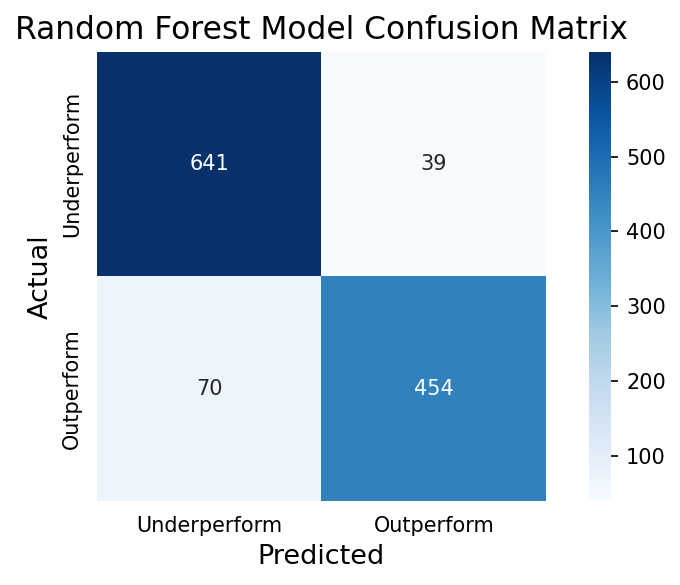

In [415]:
rfc_confusion = confusion_matrix(y3_test,pred3_rfc)
plt.figure(dpi=150)
hm = sns.heatmap(rfc_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')
hm.set_xticklabels(labels=['Underperform','Outperform'], rotation=0)
hm.set_yticklabels(labels=['Underperform','Outperform'], rotation=90, va='center')
hm.tick_params(left=False, bottom=False)

plt.xlabel('Predicted', fontsize=13)
plt.ylabel('Actual', fontsize=13)
plt.title('Random Forest Model Confusion Matrix', fontsize=15)
plt.tight_layout()
plt.savefig('../Charts/test_confusion_matrix.png')

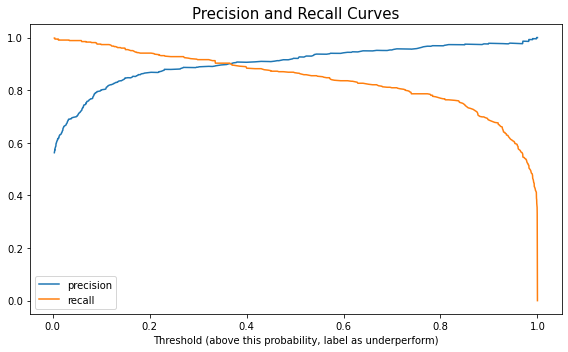

In [437]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

grid_pred_proba_rfc = rfc3.predict_proba(X3_test)[:,1]
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y3_test, grid_pred_proba_rfc)

plt.figure(figsize=(8,5))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as underperform)');
plt.title('Precision and Recall Curves', fontsize=15)
plt.tight_layout()
plt.savefig('../Charts/test_precision_recall_thres.png')

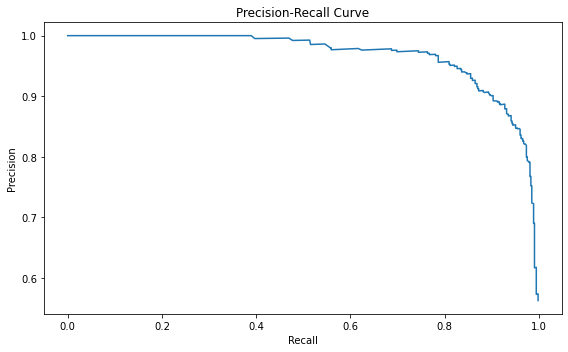

In [417]:
plt.figure(figsize=(8,5))
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.savefig('../Charts/test_precision_recall.png')

In [418]:
fpr, tpr, thresoholds = roc_curve(y3_test, grid_pred_proba_rfc)

ROC AUC score =  0.9735308149977548


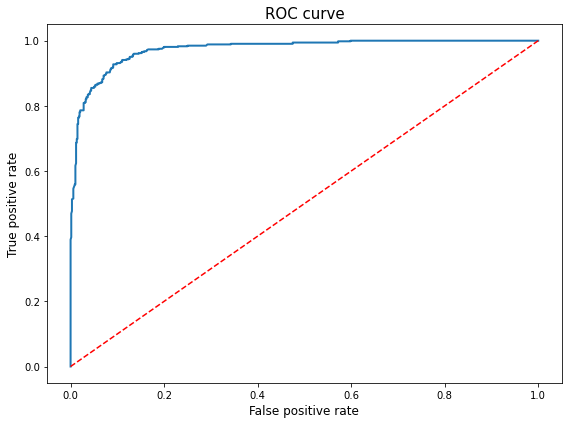

In [419]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='red',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.title('ROC curve', fontsize=15)
plt.tight_layout()
plt.savefig('../Charts/test_roc_curve.png')

print("ROC AUC score = ", roc_auc_score(y3_test, grid_pred_proba_rfc))

In [420]:
log_loss(y3_test, rfc3.predict_proba(X3_test))

0.21521696970759377

## Interpreting Results

### Feature importance

#### Gini importance (or mean decrease impurity)

Text(0.5, 0, 'Random Forest Feature Importance')

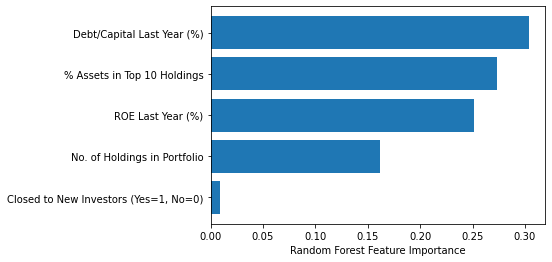

In [421]:
sorted_idx_gini = rfc3.feature_importances_.argsort()
plt.barh(X3_test.columns[sorted_idx_gini], rfc3.feature_importances_[sorted_idx_gini])
plt.xlabel("Random Forest Feature Importance")

#### Permutation importance

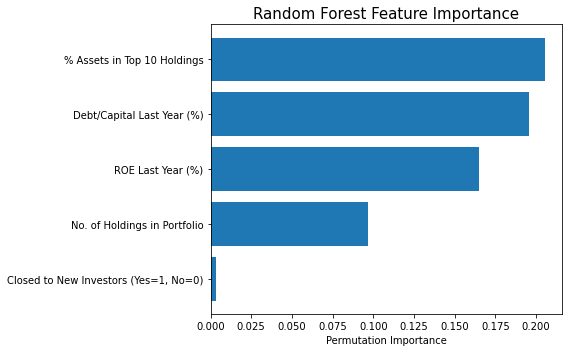

In [422]:
plt.figure(figsize=(8,5))
perm_importance = permutation_importance(rfc3, X3_test, y3_test)
sorted_idx_perm = perm_importance.importances_mean.argsort()
plt.barh(X3_test.columns[sorted_idx_perm], perm_importance.importances_mean[sorted_idx_perm])
plt.title('Random Forest Feature Importance', fontsize=15)
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.savefig('../Charts/feature_importance.png')

### Error analysis

In [423]:
FN = df3_mf_test[(y3_test == 1) & (pred3_rfc[:].T == 0)]

In [424]:
FP = df3_mf_test[(y3_test == 0) & (pred3_rfc[:].T == 1)]

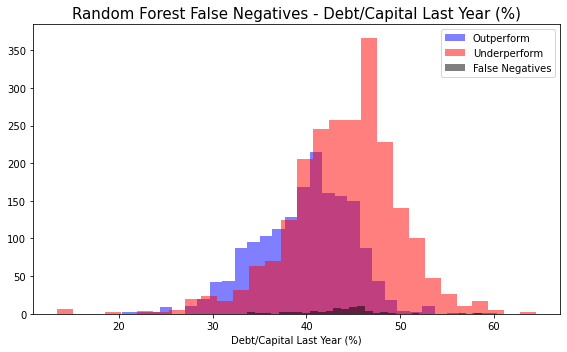

In [425]:
plt.figure(figsize=(8,5))
df3_mf_train[df3_mf_train['Outperform / Underperform']==1]['Debt/Capital Last Year (%)'].hist(alpha=0.5,
                                              color='blue', bins=30,label='Outperform')
df3_mf_train[df3_mf_train['Outperform / Underperform']==0]['Debt/Capital Last Year (%)'].hist(alpha=0.5,
                                              color='red', bins=30,label='Underperform')
FN['Debt/Capital Last Year (%)'].hist(alpha=0.5, color='black', bins=30,label='False Negatives')

plt.legend()
plt.grid(b=None)
plt.title('Random Forest False Negatives - Debt/Capital Last Year (%)', fontsize=15)
plt.xlabel('Debt/Capital Last Year (%)')
plt.tight_layout()
plt.savefig('../Charts/dist_false_negatives.png')

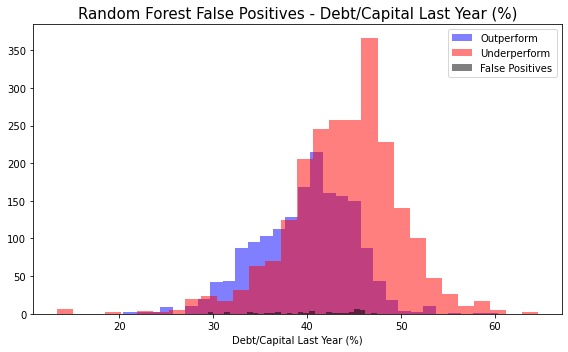

In [426]:
plt.figure(figsize=(8,5))
df3_mf_train[df3_mf_train['Outperform / Underperform']==1]['Debt/Capital Last Year (%)'].hist(alpha=0.5,
                                              color='blue', bins=30,label='Outperform')
df3_mf_train[df3_mf_train['Outperform / Underperform']==0]['Debt/Capital Last Year (%)'].hist(alpha=0.5,
                                              color='red', bins=30,label='Underperform')
FP['Debt/Capital Last Year (%)'].hist(alpha=0.5, color='black', bins=30,label='False Positives')

plt.legend()
plt.grid(b=None)
plt.title('Random Forest False Positives - Debt/Capital Last Year (%)', fontsize=15)
plt.xlabel('Debt/Capital Last Year (%)')
plt.tight_layout()
plt.savefig('../Charts/dist_false_positives.png')

## Save Model for Web App

In [433]:
rfc3.feature_names = list(X3_test.columns[perm_importance.importances_mean.argsort()[::-1]])

In [434]:
reverse_binary_mapper = {1:'Outperform', 0:'Underperform'}
df3_mf_test['Outperform / Underperform'] = df3_mf_test['Outperform / Underperform'].replace(reverse_binary_mapper)
rfc3.target_names = df3_mf_test['Outperform / Underperform'].unique()

In [435]:
with open('../Web_app/predictor_app/models/rfc3.pkl', 'wb') as f:
    pkl.dump(rfc3, f)

In [436]:
rfc3.feature_names

['% Assets in Top 10 Holdings',
 'Debt/Capital Last Year (%)',
 'ROE Last Year (%)',
 'No. of Holdings in Portfolio',
 'Closed to New Investors (Yes=1, No=0)']